# Exploratory Data Analysis
This notebook creates features from raw tables and visualizes the results.

## 1. Set environment
Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import statsmodels.api as sm
import re

Read datasets

In [2]:
d1 = pd.read_csv('../../dat/videoDetails.csv')
d2 = pd.read_csv('../../dat/videoFlags.csv')
df = pd.merge(d1, d2, on='videoId', how='right')
del d1, d2

## 2. Feature creation
Set date type to `publishedAt`
2021-11-05T12:01:03Z

In [3]:
df['publishedAt'] = pd.to_datetime(df['publishedAt'], format='%Y-%m-%dT%H:%M:%SZ')

Turn `definition` to dummy

In [4]:
df['definition'] = df['definition'].replace({'sd':'0','hd':'1'}).astype(int)

Create targets from counters

In [5]:
for h in [i * 12 for i in  range(1,7)]:
    h = str(h)
    df['ncr1Post' + h] = df['post' + h + 'CommentsNeg1'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)
    df['ncr2Post' + h] = df['post' + h + 'CommentsNeg2'] / df['post' + h + 'CommentsNum'].replace(0, 0.1)

Analyze most important words in video titles to create dummy variables

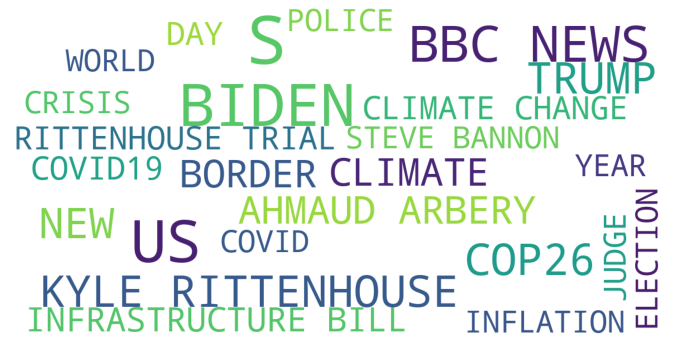

In [6]:
# All titles to single text
text = ' '.join(df['title'].str.title().tolist())

# Remove annoying strings
for string in ["'s",".","-"]:
    text = text.replace(string, '')

# All words to uppercase
text = text.upper()
# Stopwords
stopwords = set(list(STOPWORDS) + ['SAY','SAYS'])

# Plot wordcloud
wordcloud = WordCloud(
    background_color='white',
    max_words=25,
    stopwords=stopwords,
    max_font_size=40, 
    scale=3,
    random_state=42
).generate(text)

fig = plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [7]:
# Title to lowercase
df['title'] = df['title'].str.lower()

# Dictionary of keywords
keywords = {
    'biden':['biden'],
    'trump':['trump'],
    'rittenhouse':['rittenhouse'],
    'climate':['cop26','cop 26','climate'],
    'border':['border'],
    'economy':['inflation','infrastructure'],
    'covid':['covid','covid19','covid-19'],
    'arbery':['arbery'],
    'bannon':['bannon']
}

# Create Indicator variables
for topic in keywords:
    words = keywords[topic]
    df[topic] = np.where(df['title'].str.contains('|'.join(words)), 1, 0)

Video title sentiment

In [8]:
clf = SentimentIntensityAnalyzer()
df['titleSentiment'] = df['title'].apply(lambda x: clf.polarity_scores(x)['compound'])

Translate `duration` to seconds.

In [32]:
string = '1H12S'

In [33]:
string.index('S')

3

In [9]:
# Parser
def to_seconds(string=None):
    string.replace('PT','')
    if 'S' not in string:
        string += '0S'
    if 'M' not in string:
        string += ''
    if 'H' in string:
        h = string.index('H')
        if ''
        m = string.index('M')
        secs = re.sub('[^0-9]','',string[-3:])
        mins = re.sub('[^0-9]','',string[m-2:m+1])
        hours = re.sub('[^0-9]','',string[h-2:h+1])
    elif 'M' in string:
        m = string.index('M')
        secs = re.sub('[^0-9]','',string[-3:])
        mins = re.sub('[^0-9]','',string[m-2:m+1])
        hours = 0
    else:
        secs = re.sub('[^0-9]','',string[-3:])
        mins, hours = 0, 0
    return int(hours) * 60 * 60 + int(mins) * 60 + int(secs)

# Translate
df['duration'] = df['duration'].apply(lambda x: to_seconds(x))

ValueError: substring not found

In [36]:
def YTDurationToSeconds(duration):
  match = re.match('PT(\d+H)?(\d+M)?(\d+S)?', duration).groups()
  hours = _js_parseInt(match[0]) if match[0] else 0
  minutes = _js_parseInt(match[1]) if match[1] else 0
  seconds = _js_parseInt(match[2]) if match[2] else 0
  return hours * 3600 + minutes * 60 + seconds
def _js_parseInt(string):
    return int(''.join([x for x in string if x.isdigit()]))

In [19]:
x = df.loc[df['duration'].str.contains('H'), 'duration']
x.str.contains('M') == 

59      PT1H30M14S
61       PT1H1M25S
62      PT7H32M57S
65       PT7H1M35S
68      PT1H28M45S
180      PT1H7M10S
275     PT2H10M36S
391        PT2H37M
397      PT1H14M7S
400       PT3H5M1S
411     PT2H37M31S
579      PT1H1M47S
611     PT2H19M45S
630      PT1H2M36S
654        PT1H50S
750        PT1H50S
756     PT1H27M59S
761     PT1H32M21S
769     PT9H37M45S
776     PT9H43M39S
1166    PT2H37M40S
1168    PT2H48M44S
1172     PT3H5M16S
1191    PT4H50M52S
1194    PT1H35M10S
1195    PT1H51M56S
1235    PT6H22M15S
1257     PT1H9M46S
1407      PT1H2M8S
1408     PT1H1M55S
1415     PT1H2M48S
1418     PT1H3M17S
1443    PT1H34M23S
1471     PT1H6M40S
1473       PT1H31S
1512    PT1H32M22S
Name: duration, dtype: object

Sort data by upload date

In [ ]:
df = df.sort_values('publishedAt', ascending=True).reset_index(drop=True)

Treatment indicator

In [ ]:
df['treat'] = (df['publishedAt'] > '2021-11-10').astype(int)

## 3. EDA
List of targets

In [ ]:
targets = ['Post' + str(h * 12) for h in range(1,7)]

Plot time series

In [ ]:
for target in targets:
    t = df.loc[df[target.lower() + 'CommentsNum'] > 0, ['publishedAt','ncr1'+target,'ncr2'+target]]
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.set_figwidth(15)
    fig.suptitle('Comments posted ' + target[-2:] + ' hours after release')
    ax[0].set_title('Negative comment ratio')
    ax[0].scatter(t['publishedAt'], t['ncr1'+target], color='orangered', alpha=0.7)
    ax[1].set_title('Negative sentiment ratio')
    ax[1].scatter(t['publishedAt'], t['ncr2'+target], color='lightcoral', alpha=0.7)
    plt.show()

Difference in means

In [ ]:
for target in targets:
    print(df.groupby('treat')[['ncr1' + target,'ncr2' + target]].mean().round(2))
    print('\n')

Preliminary regressions

In [ ]:
# Add constant
df['const'] = 1

# List of independent variables
X = ['treat','const','titleSentiment','definition','biden','trump',
     'rittenhouse','climate','border','economy','covid','arbery','bannon']

# Fit first OLS
m0 = sm.OLS(endog=df['ncr1Post12'], exog=df[X])
m0_fit = m0.fit(cov_type='HC0')
p = m0_fit.pvalues
print(m0_fit.summary().tables[1])

# Backwards stepwise selection
while any(p > 0.1):
    p = m0_fit.pvalues.drop(['const','treat'])
    p = p[p > 0.1]
    if len(p) > 0:
        X.remove(p.idxmax())
        m0 = sm.OLS(endog=df['ncr1Post12'], exog=df[X])
        m0_fit = m0.fit(cov_type='HC0')
        print('\nDropped ', p.idxmax())
        print(m0_fit.summary().tables[1])